### Import and init GPU

In [1]:
from IPython.display import Audio

In [2]:
import sys
sys.path.append('../../../')

In [3]:
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import argparse
import time
import itertools
from copy import deepcopy
import tensorflow as tf

from tuner import HyperparameterTuner
from tuner import MyTask

use_tpu = False
use_gpu = True

if use_tpu:
    from tensorflow.contrib import tpu
    from tensorflow.contrib.cluster_resolver import TPUClusterResolver

if use_gpu:
    import os
    
%load_ext autoreload
%autoreload 2

In [4]:
if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

In [5]:
if use_tpu:
    tpu_cluster = TPUClusterResolver(tpu=[tpu_name]).get_master()
    sess = tf.Session(tpu_cluster)
    sess.run(tpu.initialize_system())
elif use_gpu:
    sess = tf.Session(config=config)
else:
    sess = tf.Session()

In [6]:
from resnet import Network

In [7]:
network = Network()

In [8]:
task_home = ''
if use_tpu:
    pass
#     task_home = 'gs://continual_learning/permMNIST_EWC/'
else:
    task_home = '../../../../'

cur_dir = './'
checkpoint_path = cur_dir + 'checkpoints_5_3/'
summaries_path = cur_dir + 'summaries_5_3/'
data_path = task_home + 'cifar-100-python/'
split_path = './split.txt' 
if use_tpu:
    tpu_name = 'gectpu'
    
BATCH_SIZE = 128

### Dataset loading functions

In [9]:
label_smooth_param = 0

def splitDataset(dataset, dataset_split, seed):
    np.random.seed(seed)
    task_list = []
    train_labels = np.argmax(dataset.train.labels, axis=1)
    validation_labels = np.argmax(dataset.validation.labels, axis=1)
    test_labels = np.argmax(dataset.test.labels, axis=1)
    for i in range(len(dataset_split)):
        cur_train_indices = [False] * dataset.train.images.shape[0]
        cur_validation_indices = [False] * dataset.validation.images.shape[0]
        cur_test_indices = [False] * dataset.test.images.shape[0]
        for j in range(len(dataset_split[i])):
            cur_train_indices = np.logical_or(cur_train_indices, (train_labels == dataset_split[i][j]))
            cur_validation_indices = np.logical_or(cur_validation_indices, (validation_labels == dataset_split[i][j]))
            cur_test_indices = np.logical_or(cur_test_indices, (test_labels == dataset_split[i][j]))

        task = deepcopy(dataset)
        task.train.images = task.train.images[cur_train_indices]
        task.train.labels = task.train.labels[cur_train_indices]
        task.validation.images = task.validation.images[cur_validation_indices]
        task.validation.labels = task.validation.labels[cur_validation_indices]
        task.test.images = task.test.images[cur_test_indices]
        task.test.labels = task.test.labels[cur_test_indices]
        task = MyTask(task)
        task_list.append(task)

    return task_list
    
def smoothLabels(dataset):
    train_labels = dataset.train.labels
    train_labels_argmax = np.argmax(train_labels, axis=1)
    train_labels = train_labels + label_smooth_param / (train_labels.shape[1] - 1)
    train_labels[range(train_labels.shape[0]), train_labels_argmax] = 1 - label_smooth_param
    dataset.train._labels = train_labels

class TempDataset(object):
    def __init__(self):
        self.images = None
        self.labels = None
    
class TempTask(object):
    def __init__(self):
        self.train = TempDataset()
        self.validation = TempDataset()
        self.test = TempDataset()
    
    
def readDatasets():
    num_class = 100
    class_per_task = 5
    k = 0
    labels_list = list(range(num_class))
    seed = 3
    np.random.seed(seed)
    np.random.shuffle(labels_list)
    split = []
    task_weights = []
    while (k < num_class):
        split.append(labels_list[k : k + class_per_task])
        task_weights.append(class_per_task / num_class)
        k += class_per_task
        
    num_tasks = len(split)
    
    with open(data_path + 'train', 'rb') as f:
        f_train_data = pickle.load(f, encoding='bytes')
        
    with open(data_path + 'test', 'rb') as f:
        f_test_data = pickle.load(f, encoding='bytes')
        
    cifar_100 = TempTask()
    temp_train_labels = np.array(f_train_data[b'fine_labels'], dtype=np.int32)
    temp_test_labels = np.array(f_test_data[b'fine_labels'], dtype=np.int32)
    f_train_data[b'fine_labels'] = np.zeros((temp_train_labels.shape[0], num_class))
    (f_train_data[b'fine_labels'])[range(temp_train_labels.shape[0]), temp_train_labels] = 1
    f_test_data[b'fine_labels'] = np.zeros((temp_test_labels.shape[0], num_class))
    (f_test_data[b'fine_labels'])[range(temp_test_labels.shape[0]), temp_test_labels] = 1
    f_train_data[b'data'] = np.reshape(f_train_data[b'data'], (-1, 3, 32, 32))
    f_test_data[b'data'] = np.reshape(f_test_data[b'data'], (-1, 3, 32, 32))
    f_train_data[b'data'] = np.transpose(f_train_data[b'data'], (0, 2, 3, 1))
    f_test_data[b'data'] = np.transpose(f_test_data[b'data'], (0, 2, 3, 1))
    
    tr_data = f_train_data[b'data']
    te_data = f_test_data[b'data']
    # normalizing data
    avg = np.mean(tr_data, axis=(0, 1, 2))
    std = np.std(tr_data, axis=(0, 1, 2))
    
    f_train_data[b'data'] = (tr_data - avg) / std
    f_test_data[b'data'] = (te_data - avg) / std
    
    seed = 0
    np.random.seed(0)
    shuffle_train_perm = np.random.permutation(f_train_data[b'data'].shape[0])
    f_train_data[b'data'] = f_train_data[b'data'][shuffle_train_perm]
    f_train_data[b'fine_labels'] = f_train_data[b'fine_labels'][shuffle_train_perm]
    
    num_val_per_class = 20
    
    for i in range(num_class):
        pos = (np.argmax(f_train_data[b'fine_labels'], axis=1) == i)
        
        if (i == 0):
            cifar_100.validation.images = (f_train_data[b'data'][pos])[0 : num_val_per_class]
            cifar_100.validation.labels = (f_train_data[b'fine_labels'][pos])[0 : num_val_per_class]

            cifar_100.train.images = (f_train_data[b'data'][pos])[num_val_per_class : ]
            cifar_100.train.labels = (f_train_data[b'fine_labels'][pos])[num_val_per_class : ]
        else:
            cifar_100.validation.images = np.concatenate((cifar_100.validation.images, (f_train_data[b'data'][pos])[0 : num_val_per_class]))
            cifar_100.validation.labels = np.concatenate((cifar_100.validation.labels, (f_train_data[b'fine_labels'][pos])[0 : num_val_per_class]))

            cifar_100.train.images = np.concatenate((cifar_100.train.images, (f_train_data[b'data'][pos])[num_val_per_class : ]))
            cifar_100.train.labels = np.concatenate((cifar_100.train.labels, (f_train_data[b'fine_labels'][pos])[num_val_per_class : ]))
        
    cifar_100.test.images = f_test_data[b'data']
    cifar_100.test.labels = f_test_data[b'fine_labels']
    
    shuffle_train_perm = np.random.permutation(cifar_100.train.images.shape[0])
    cifar_100.train.images = cifar_100.train.images[shuffle_train_perm]
    cifar_100.train.labels = cifar_100.train.labels[shuffle_train_perm]
    
    if (label_smooth_param != 0):
        smoothLabels(cifar_100)
        
    task_list = splitDataset(cifar_100, split, seed)
    return split, num_tasks, task_weights, task_list

### Create tuner object and train!!

In [10]:
input_shape = (32, 32, 3)
output_shape = (100, )

In [11]:
tuner = HyperparameterTuner(sess=sess, network=network, 
                            input_shape=input_shape, output_shape=output_shape,
                            checkpoint_path=checkpoint_path, summaries_path=summaries_path, 
                            readDatasets=readDatasets, load_best_hparams=False)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [12]:
tuner.setPerExampleAppend(1.0)
tuner.updateTunerHparams({'mask_softmax' : True})

### Training each task separately

In [ ]:
t = 0
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)

tuner.hparams_list[t] = hparams

In [ ]:
num_epochs = 160
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 10

In [ ]:
start_time = time.time()
best_avg, best_hparams = tuner.tuneOnTask(t, BATCH_SIZE, 
                                          save_weights=False, 
                                          num_updates=num_updates, verbose=True, 
                                          random_crop_flip=True)
print("time taken : %d" % (time.time() - start_time))
sound_file = '/mnt/a99/d0/shriramsb/code/Alan Walker - Alone.mp3'
Audio(sound_file, autoplay=True)

In [ ]:
import math
plt.rcParams['figure.figsize'] = [10, 5]
lr_scatter = ([math.log10(h['learning_rate']) for h in hparams])
dropout_scatter = [h['dropout_hidden_prob'] for h in hparams]
colors = []
for i in range(len(hparams)):
    cur_hparam_tuple = tuner.hparamsDictToTuple(hparams[i], tuner.tuner_hparams)
    colors.append(tuner.results_list[t][cur_hparam_tuple]['best_avg'])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], dropout_scatter[i]))
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_avg_updates // updates_per_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][0], color='b', )
# plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

In [ ]:
# print(best_avg, best_hparams)
VALIDATION_BATCH_SIZE = 128
print(tuner.validationAccuracy(t, VALIDATION_BATCH_SIZE, restore_model=False))

In [ ]:
t = 1
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)

tuner.hparams_list[t] = hparams

In [ ]:
num_epochs = 160
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 10

In [ ]:
start_time = time.time()
best_avg, best_hparams = tuner.tuneOnTask(t, BATCH_SIZE, 
                                          save_weights=False, 
                                          num_updates=num_updates, verbose=True, 
                                          random_crop_flip=True)
print("time taken : %d" % (time.time() - start_time))
sound_file = '/mnt/a99/d0/shriramsb/code/Alan Walker - Alone.mp3'
Audio(sound_file, autoplay=True)

In [ ]:
import math
plt.rcParams['figure.figsize'] = [10, 5]
lr_scatter = ([math.log10(h['learning_rate']) for h in hparams])
dropout_scatter = [h['dropout_hidden_prob'] for h in hparams]
colors = []
for i in range(len(hparams)):
    cur_hparam_tuple = tuner.hparamsDictToTuple(hparams[i], tuner.tuner_hparams)
    colors.append(tuner.results_list[t][cur_hparam_tuple]['best_avg'])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], dropout_scatter[i]))
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_avg_updates // updates_per_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][0], color='b', )
plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

### Train tasks together

In [13]:
t = 19
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)
    
for i in range(0, t + 1):
    tuner.hparams_list[i] = hparams
    

In [14]:
num_hparams = len(hparams)
num_epochs = 70
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 100

In [15]:
best_avg, best_hparams_index = tuner.tuneTasksInRange(0, t, BATCH_SIZE, num_hparams, 
                                                        num_updates=num_updates, verbose=True, 
                                                        random_crop_flip=True)

Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0
epoch: 1, iter: 0/19, validation accuracies: [0.31999999], average train loss: 1.904899, average train accuracy: 0.293586
epoch: 2, iter: 0/19, validation accuracies: [0.38999999], average train loss: 1.429543, average train accuracy: 0.341283
epoch: 3, iter: 0/19, validation accuracies: [0.25], average train loss: 1.406448, average train accuracy: 0.371299
epoch: 4, iter: 0/19, validation accuracies: [0.38], average train loss: 1.339526, average train accuracy: 0.403372
epoch: 5, iter: 0/19, validation accuracies: [0.44], average train loss: 1.258126, average train accuracy: 0.449836
epoch: 5, iter: 5/19, loss: 1.234937, accuracy: 0.515625
epoch: 6, iter: 0/19, validation accuracies: [0.41999999], average train loss: 1.249560, average train accuracy: 0.495888
epoch: 7, iter: 0/19, validation accuracies: [0.56999999], average 

epoch: 62, iter: 0/19, validation accuracies: [0.75999999], average train loss: 0.250185, average train accuracy: 0.904194
epoch: 63, iter: 0/19, validation accuracies: [0.75], average train loss: 0.222125, average train accuracy: 0.914062
epoch: 63, iter: 3/19, loss: 0.234697, accuracy: 0.914062
epoch: 64, iter: 0/19, validation accuracies: [0.75], average train loss: 0.228896, average train accuracy: 0.918586
epoch: 65, iter: 0/19, validation accuracies: [0.75999999], average train loss: 0.224943, average train accuracy: 0.916941
epoch: 66, iter: 0/19, validation accuracies: [0.75], average train loss: 0.214581, average train accuracy: 0.923931
epoch: 67, iter: 0/19, validation accuracies: [0.76999998], average train loss: 0.182320, average train accuracy: 0.932566
epoch: 68, iter: 0/19, validation accuracies: [0.75], average train loss: 0.192812, average train accuracy: 0.931743
epoch: 68, iter: 8/19, loss: 0.170022, accuracy: 0.937500
epoch: 69, iter: 0/19, validation accuracies: [

epoch: 42, iter: 0/19, validation accuracies: [0.63       0.73000002], average train loss: 0.551080, average train accuracy: 0.800987
epoch: 42, iter: 2/19, loss: 0.476441, accuracy: 0.835938
epoch: 43, iter: 0/19, validation accuracies: [0.60000002 0.72000003], average train loss: 0.547559, average train accuracy: 0.799342
epoch: 44, iter: 0/19, validation accuracies: [0.69       0.68000001], average train loss: 0.569377, average train accuracy: 0.807977
epoch: 45, iter: 0/19, validation accuracies: [0.60000002 0.69999999], average train loss: 0.614216, average train accuracy: 0.781250
epoch: 46, iter: 0/19, validation accuracies: [0.67000002 0.77999997], average train loss: 0.552551, average train accuracy: 0.799342
epoch: 47, iter: 0/19, validation accuracies: [0.60000002 0.63999999], average train loss: 0.522698, average train accuracy: 0.819079
epoch: 47, iter: 7/19, loss: 0.608998, accuracy: 0.781250
epoch: 48, iter: 0/19, validation accuracies: [0.69999999 0.76999998], average t

epoch: 20, iter: 0/19, validation accuracies: [0.64999998 0.60000002 0.51999998], average train loss: 1.004878, average train accuracy: 0.633635
epoch: 21, iter: 0/19, validation accuracies: [0.51999998 0.54000002 0.52999997], average train loss: 0.951145, average train accuracy: 0.678454
epoch: 21, iter: 1/19, loss: 0.939308, accuracy: 0.734375
epoch: 22, iter: 0/19, validation accuracies: [0.62       0.57999998 0.56999999], average train loss: 0.924343, average train accuracy: 0.676398
epoch: 23, iter: 0/19, validation accuracies: [0.58999997 0.5        0.56      ], average train loss: 0.960065, average train accuracy: 0.667352
epoch: 24, iter: 0/19, validation accuracies: [0.67000002 0.58999997 0.55000001], average train loss: 0.961068, average train accuracy: 0.661595
epoch: 25, iter: 0/19, validation accuracies: [0.63       0.55000001 0.60000002], average train loss: 0.907982, average train accuracy: 0.689556
epoch: 26, iter: 0/19, validation accuracies: [0.62       0.57999998 0.5

time taken: %f 0.6948230266571045
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_5_3/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=2.ckpt-1330
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=3
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=2
INFO:tensorflow:Restoring parameters from ./checkpoints_5_3/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=2.ckpt-1330
epoch: 1, iter: 0/19, validation accuracies: [0.28999999 0.33000001 0.03       0.17      ], average train loss: 3.251560, average train accuracy: 0.201480
epoch: 2, iter: 0/19, validation accuracies: [0.5        0.25999999 0.28     

epoch: 46, iter: 0/19, validation accuracies: [0.49000001 0.69999999 0.69       0.73000002], average train loss: 0.709626, average train accuracy: 0.769737
epoch: 47, iter: 0/19, validation accuracies: [0.61000001 0.66000003 0.72000003 0.77999997], average train loss: 0.727839, average train accuracy: 0.761924
epoch: 47, iter: 7/19, loss: 0.566432, accuracy: 0.789062
epoch: 48, iter: 0/19, validation accuracies: [0.41       0.63999999 0.58999997 0.88999999], average train loss: 0.680594, average train accuracy: 0.778372
epoch: 49, iter: 0/19, validation accuracies: [0.49000001 0.69999999 0.74000001 0.72000003], average train loss: 0.649363, average train accuracy: 0.785362
epoch: 50, iter: 0/19, validation accuracies: [0.64999998 0.76999998 0.73000002 0.81999999], average train loss: 0.599572, average train accuracy: 0.785773
epoch: 51, iter: 0/19, validation accuracies: [0.63       0.75999999 0.81       0.81      ], average train loss: 0.532877, average train accuracy: 0.817845
epoch:

epoch: 17, iter: 0/19, validation accuracies: [0.54000002 0.46000001 0.69       0.69999999 0.51999998], average train loss: 1.094544, average train accuracy: 0.625411
epoch: 18, iter: 0/19, validation accuracies: [0.44       0.70999998 0.57999998 0.75999999 0.57999998], average train loss: 1.041900, average train accuracy: 0.643503
epoch: 19, iter: 0/19, validation accuracies: [0.43000001 0.58999997 0.63999999 0.68000001 0.47999999], average train loss: 1.069310, average train accuracy: 0.643503
epoch: 20, iter: 0/19, validation accuracies: [0.41999999 0.64999998 0.63999999 0.69999999 0.58999997], average train loss: 1.001622, average train accuracy: 0.658717
epoch: 21, iter: 0/19, validation accuracies: [0.43000001 0.68000001 0.55000001 0.74000001 0.61000001], average train loss: 0.958014, average train accuracy: 0.659128
epoch: 21, iter: 1/19, loss: 1.063058, accuracy: 0.617188
epoch: 22, iter: 0/19, validation accuracies: [0.54000002 0.56999999 0.54000002 0.73000002 0.38999999], ave

epoch: 64, iter: 0/19, validation accuracies: [0.67000002 0.79000002 0.74000001 0.85000002 0.67000002], average train loss: 0.489923, average train accuracy: 0.835938
epoch: 65, iter: 0/19, validation accuracies: [0.68000001 0.77999997 0.75999999 0.82999998 0.67000002], average train loss: 0.495354, average train accuracy: 0.831414
epoch: 66, iter: 0/19, validation accuracies: [0.67000002 0.79000002 0.74000001 0.85000002 0.69      ], average train loss: 0.571447, average train accuracy: 0.814556
epoch: 67, iter: 0/19, validation accuracies: [0.67000002 0.77999997 0.75       0.82999998 0.69      ], average train loss: 0.534694, average train accuracy: 0.824836
epoch: 68, iter: 0/19, validation accuracies: [0.67000002 0.80000001 0.75999999 0.82999998 0.69999999], average train loss: 0.515306, average train accuracy: 0.829359
epoch: 68, iter: 8/19, loss: 0.595055, accuracy: 0.820312
epoch: 69, iter: 0/19, validation accuracies: [0.66000003 0.79000002 0.75       0.81999999 0.69      ], ave

epoch: 31, iter: 11/19, loss: 1.143277, accuracy: 0.632812
epoch: 32, iter: 0/19, validation accuracies: [0.61000001 0.62       0.60000002 0.68000001 0.63999999 0.56      ], average train loss: 0.950396, average train accuracy: 0.669819
epoch: 33, iter: 0/19, validation accuracies: [0.41       0.68000001 0.64999998 0.75       0.52999997 0.52999997], average train loss: 0.943039, average train accuracy: 0.670641
epoch: 34, iter: 0/19, validation accuracies: [0.44       0.69       0.63999999 0.76999998 0.52999997 0.5       ], average train loss: 0.923496, average train accuracy: 0.677220
epoch: 35, iter: 0/19, validation accuracies: [0.44       0.72000003 0.67000002 0.63       0.62       0.49000001], average train loss: 0.951980, average train accuracy: 0.673520
epoch: 36, iter: 0/19, validation accuracies: [0.56999999 0.63999999 0.58999997 0.69999999 0.63999999 0.49000001], average train loss: 0.882202, average train accuracy: 0.659128
epoch: 36, iter: 16/19, loss: 1.092197, accuracy: 0

Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=5
INFO:tensorflow:Restoring parameters from ./checkpoints_5_3/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=5.ckpt-1330
epoch: 1, iter: 0/19, validation accuracies: [0.         0.01       0.05       0.34       0.15000001 0.08
 0.12      ], average train loss: 4.795926, average train accuracy: 0.071957
epoch: 2, iter: 0/19, validation accuracies: [0.09       0.08       0.16       0.31999999 0.2        0.25999999
 0.27000001], average train loss: 3.111122, average train accuracy: 0.207648
epoch: 3, iter: 0/19, validation accuracies: [0.22       0.18000001 0.13       0.33000001 0.25       0.18000001
 0.2       ], average train loss: 2.666651, average train accuracy: 0.280428
epoch: 4, iter: 0/19, validation accuracies: [0.17       0.41       0.28999999 0.31999999 0.

epoch: 41, iter: 0/19, validation accuracies: [0.50999999 0.56       0.60000002 0.69999999 0.50999999 0.46000001
 0.57999998], average train loss: 1.081312, average train accuracy: 0.675987
epoch: 42, iter: 0/19, validation accuracies: [0.47999999 0.60000002 0.61000001 0.63999999 0.63       0.56
 0.61000001], average train loss: 0.975743, average train accuracy: 0.684211
epoch: 42, iter: 2/19, loss: 0.857041, accuracy: 0.734375
epoch: 43, iter: 0/19, validation accuracies: [0.47       0.61000001 0.69       0.74000001 0.61000001 0.61000001
 0.56      ], average train loss: 0.921695, average train accuracy: 0.705592
epoch: 44, iter: 0/19, validation accuracies: [0.60000002 0.63999999 0.60000002 0.52999997 0.52999997 0.5
 0.49000001], average train loss: 0.970570, average train accuracy: 0.696135
epoch: 45, iter: 0/19, validation accuracies: [0.63       0.63       0.54000002 0.63       0.69       0.5
 0.61000001], average train loss: 0.965148, average train accuracy: 0.707648
epoch: 46, i

epoch: 5, iter: 5/19, loss: 1.971422, accuracy: 0.351562
epoch: 6, iter: 0/19, validation accuracies: [0.43000001 0.40000001 0.51999998 0.5        0.43000001 0.38
 0.49000001 0.34      ], average train loss: 1.797544, average train accuracy: 0.418586
epoch: 7, iter: 0/19, validation accuracies: [0.47       0.46000001 0.41       0.58999997 0.44       0.55000001
 0.38999999 0.38      ], average train loss: 1.601346, average train accuracy: 0.449424
epoch: 8, iter: 0/19, validation accuracies: [0.52999997 0.57999998 0.56       0.61000001 0.43000001 0.38
 0.43000001 0.25999999], average train loss: 1.658567, average train accuracy: 0.470806
epoch: 9, iter: 0/19, validation accuracies: [0.46000001 0.41       0.54000002 0.55000001 0.56999999 0.54000002
 0.40000001 0.37      ], average train loss: 1.571426, average train accuracy: 0.446546
epoch: 10, iter: 0/19, validation accuracies: [0.50999999 0.56999999 0.44       0.49000001 0.54000002 0.43000001
 0.28       0.34      ], average train los

epoch: 45, iter: 0/19, validation accuracies: [0.51999998 0.52999997 0.56       0.70999998 0.55000001 0.58999997
 0.60000002 0.37      ], average train loss: 1.025151, average train accuracy: 0.649671
epoch: 46, iter: 0/19, validation accuracies: [0.5        0.63999999 0.73000002 0.62       0.56999999 0.66000003
 0.51999998 0.57999998], average train loss: 1.013145, average train accuracy: 0.646382
epoch: 47, iter: 0/19, validation accuracies: [0.54000002 0.50999999 0.69999999 0.60000002 0.47       0.67000002
 0.64999998 0.41999999], average train loss: 0.976113, average train accuracy: 0.650493
epoch: 47, iter: 7/19, loss: 1.131101, accuracy: 0.640625
epoch: 48, iter: 0/19, validation accuracies: [0.44999999 0.47       0.58999997 0.81       0.56       0.56999999
 0.60000002 0.56999999], average train loss: 1.044752, average train accuracy: 0.662418
epoch: 49, iter: 0/19, validation accuracies: [0.47999999 0.44       0.74000001 0.66000003 0.68000001 0.46000001
 0.66000003 0.61000001], 

epoch: 8, iter: 0/19, validation accuracies: [0.44999999 0.44       0.5        0.60000002 0.47999999 0.38999999
 0.34999999 0.28       0.34      ], average train loss: 1.665132, average train accuracy: 0.473273
epoch: 9, iter: 0/19, validation accuracies: [0.44999999 0.38       0.67000002 0.64999998 0.56999999 0.34999999
 0.51999998 0.30000001 0.40000001], average train loss: 1.499533, average train accuracy: 0.478207
epoch: 10, iter: 0/19, validation accuracies: [0.40000001 0.47999999 0.54000002 0.51999998 0.58999997 0.40000001
 0.43000001 0.30000001 0.40000001], average train loss: 1.464369, average train accuracy: 0.500411
epoch: 10, iter: 10/19, loss: 1.219816, accuracy: 0.531250
epoch: 11, iter: 0/19, validation accuracies: [0.34999999 0.36000001 0.56       0.60000002 0.47       0.38
 0.66000003 0.25999999 0.41      ], average train loss: 1.392596, average train accuracy: 0.522615
epoch: 12, iter: 0/19, validation accuracies: [0.56999999 0.56       0.56999999 0.61000001 0.47      

epoch: 46, iter: 0/19, validation accuracies: [0.37       0.58999997 0.64999998 0.63999999 0.44999999 0.62
 0.63       0.50999999 0.44      ], average train loss: 0.977358, average train accuracy: 0.642681
epoch: 47, iter: 0/19, validation accuracies: [0.38999999 0.5        0.62       0.58999997 0.58999997 0.54000002
 0.57999998 0.56       0.23      ], average train loss: 1.047702, average train accuracy: 0.636513
epoch: 47, iter: 7/19, loss: 1.353947, accuracy: 0.531250
epoch: 48, iter: 0/19, validation accuracies: [0.49000001 0.5        0.68000001 0.67000002 0.61000001 0.49000001
 0.54000002 0.47       0.47      ], average train loss: 1.068410, average train accuracy: 0.617599
epoch: 49, iter: 0/19, validation accuracies: [0.46000001 0.51999998 0.74000001 0.75       0.44999999 0.52999997
 0.63       0.44       0.40000001], average train loss: 1.012172, average train accuracy: 0.636102
epoch: 50, iter: 0/19, validation accuracies: [0.54000002 0.56       0.69999999 0.77999997 0.6000000

epoch: 7, iter: 0/19, validation accuracies: [0.52999997 0.36000001 0.50999999 0.80000001 0.60000002 0.47
 0.40000001 0.40000001 0.37       0.44      ], average train loss: 1.515951, average train accuracy: 0.469161
epoch: 8, iter: 0/19, validation accuracies: [0.50999999 0.44       0.67000002 0.68000001 0.41999999 0.36000001
 0.62       0.25999999 0.40000001 0.40000001], average train loss: 1.450044, average train accuracy: 0.481086
epoch: 9, iter: 0/19, validation accuracies: [0.56       0.30000001 0.5        0.69999999 0.63       0.41999999
 0.52999997 0.36000001 0.47       0.56      ], average train loss: 1.470857, average train accuracy: 0.493421
epoch: 10, iter: 0/19, validation accuracies: [0.43000001 0.49000001 0.5        0.70999998 0.44999999 0.41999999
 0.46000001 0.56999999 0.31       0.55000001], average train loss: 1.419460, average train accuracy: 0.505757
epoch: 10, iter: 10/19, loss: 1.400661, accuracy: 0.523438
epoch: 11, iter: 0/19, validation accuracies: [0.46000001 

epoch: 43, iter: 0/19, validation accuracies: [0.52999997 0.51999998 0.63       0.75       0.47       0.55000001
 0.60000002 0.38       0.56       0.52999997], average train loss: 1.116663, average train accuracy: 0.645559
epoch: 44, iter: 0/19, validation accuracies: [0.47999999 0.56999999 0.60000002 0.72000003 0.61000001 0.52999997
 0.58999997 0.58999997 0.41       0.50999999], average train loss: 1.152279, average train accuracy: 0.627056
epoch: 45, iter: 0/19, validation accuracies: [0.52999997 0.44999999 0.57999998 0.63999999 0.44999999 0.47
 0.49000001 0.56       0.5        0.57999998], average train loss: 1.088547, average train accuracy: 0.628701
epoch: 46, iter: 0/19, validation accuracies: [0.50999999 0.66000003 0.69999999 0.73000002 0.56       0.44
 0.47999999 0.44       0.51999998 0.57999998], average train loss: 1.067924, average train accuracy: 0.636102
epoch: 47, iter: 0/19, validation accuracies: [0.36000001 0.56       0.62       0.69       0.56999999 0.58999997
 0.63  

epoch: 3, iter: 0/19, validation accuracies: [0.36000001 0.37       0.22       0.50999999 0.08       0.34999999
 0.22       0.11       0.11       0.31999999 0.27000001], average train loss: 2.648599, average train accuracy: 0.282895
epoch: 4, iter: 0/19, validation accuracies: [0.36000001 0.47999999 0.19       0.69       0.31       0.31
 0.36000001 0.25999999 0.05       0.25       0.23999999], average train loss: 2.318460, average train accuracy: 0.321546
epoch: 5, iter: 0/19, validation accuracies: [0.47999999 0.41999999 0.34999999 0.61000001 0.20999999 0.13
 0.25999999 0.34       0.37       0.34999999 0.27000001], average train loss: 2.137251, average train accuracy: 0.387336
epoch: 5, iter: 5/19, loss: 2.131774, accuracy: 0.398438
epoch: 6, iter: 0/19, validation accuracies: [0.47       0.33000001 0.37       0.63999999 0.55000001 0.2
 0.31999999 0.33000001 0.36000001 0.49000001 0.31      ], average train loss: 1.952563, average train accuracy: 0.416941
epoch: 7, iter: 0/19, validati

epoch: 36, iter: 16/19, loss: 1.101168, accuracy: 0.625000
epoch: 37, iter: 0/19, validation accuracies: [0.41999999 0.50999999 0.63       0.75999999 0.58999997 0.46000001
 0.56       0.44999999 0.52999997 0.56999999 0.52999997], average train loss: 1.187572, average train accuracy: 0.623766
epoch: 38, iter: 0/19, validation accuracies: [0.47999999 0.56       0.52999997 0.69       0.46000001 0.54000002
 0.47       0.46000001 0.38       0.56       0.38      ], average train loss: 1.138932, average train accuracy: 0.619655
epoch: 39, iter: 0/19, validation accuracies: [0.43000001 0.54000002 0.69       0.57999998 0.50999999 0.51999998
 0.58999997 0.44       0.47999999 0.52999997 0.46000001], average train loss: 1.124567, average train accuracy: 0.640625
epoch: 40, iter: 0/19, validation accuracies: [0.44999999 0.41       0.69       0.50999999 0.56999999 0.63999999
 0.50999999 0.47999999 0.47       0.38       0.50999999], average train loss: 1.231074, average train accuracy: 0.615132
epoch

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=10 at time step 1330
calculating penultimate output...
time taken: %f 2.5676801204681396
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_5_3/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=10.ckpt-1330
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=11
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=10
INFO:tensorflow:Restoring parameters from ./checkpoints_5_3/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=10.ckpt-1330
epoch: 1, iter: 0/19, validation acc

epoch: 30, iter: 0/19, validation accuracies: [0.49000001 0.66000003 0.67000002 0.70999998 0.56       0.43000001
 0.49000001 0.52999997 0.44999999 0.63       0.41       0.47999999], average train loss: 1.230421, average train accuracy: 0.563734
epoch: 31, iter: 0/19, validation accuracies: [0.51999998 0.36000001 0.58999997 0.74000001 0.58999997 0.31
 0.57999998 0.56       0.44       0.52999997 0.49000001 0.47999999], average train loss: 1.165573, average train accuracy: 0.569901
epoch: 31, iter: 11/19, loss: 1.331919, accuracy: 0.515625
epoch: 32, iter: 0/19, validation accuracies: [0.5        0.47999999 0.64999998 0.66000003 0.55000001 0.68000001
 0.58999997 0.51999998 0.41999999 0.63       0.41       0.52999997], average train loss: 1.259345, average train accuracy: 0.549753
epoch: 33, iter: 0/19, validation accuracies: [0.41       0.46000001 0.66000003 0.73000002 0.56999999 0.49000001
 0.55000001 0.55000001 0.40000001 0.60000002 0.44       0.52999997], average train loss: 1.286161, 

epoch: 63, iter: 0/19, validation accuracies: [0.57999998 0.56       0.69999999 0.86000001 0.64999998 0.52999997
 0.61000001 0.55000001 0.55000001 0.68000001 0.50999999 0.63      ], average train loss: 0.859015, average train accuracy: 0.675164
epoch: 63, iter: 3/19, loss: 0.976271, accuracy: 0.601562
epoch: 64, iter: 0/19, validation accuracies: [0.58999997 0.55000001 0.69       0.85000002 0.66000003 0.51999998
 0.63       0.54000002 0.5        0.70999998 0.5        0.64999998], average train loss: 0.883973, average train accuracy: 0.672286
epoch: 65, iter: 0/19, validation accuracies: [0.60000002 0.54000002 0.69       0.86000001 0.67000002 0.55000001
 0.67000002 0.54000002 0.47       0.70999998 0.46000001 0.63999999], average train loss: 0.904019, average train accuracy: 0.683799
epoch: 66, iter: 0/19, validation accuracies: [0.61000001 0.56999999 0.70999998 0.82999998 0.67000002 0.54000002
 0.66000003 0.58999997 0.5        0.72000003 0.47       0.60000002], average train loss: 0.888

epoch: 20, iter: 0/19, validation accuracies: [0.44999999 0.44       0.61000001 0.72000003 0.50999999 0.40000001
 0.56       0.56999999 0.33000001 0.57999998 0.43000001 0.57999998
 0.44999999], average train loss: 1.459442, average train accuracy: 0.572368
epoch: 21, iter: 0/19, validation accuracies: [0.50999999 0.46000001 0.54000002 0.54000002 0.54000002 0.41999999
 0.41       0.49000001 0.37       0.52999997 0.54000002 0.41
 0.54000002], average train loss: 1.393628, average train accuracy: 0.570312
epoch: 21, iter: 1/19, loss: 1.412996, accuracy: 0.585938
epoch: 22, iter: 0/19, validation accuracies: [0.46000001 0.55000001 0.64999998 0.69       0.5        0.43000001
 0.47999999 0.44999999 0.37       0.47       0.27000001 0.50999999
 0.51999998], average train loss: 1.504794, average train accuracy: 0.560444
epoch: 23, iter: 0/19, validation accuracies: [0.49000001 0.47999999 0.57999998 0.67000002 0.36000001 0.43000001
 0.41999999 0.56999999 0.52999997 0.51999998 0.50999999 0.44
 0.

epoch: 51, iter: 0/19, validation accuracies: [0.49000001 0.57999998 0.63       0.75999999 0.63999999 0.49000001
 0.50999999 0.64999998 0.47       0.66000003 0.50999999 0.63
 0.63999999], average train loss: 1.135855, average train accuracy: 0.659128
epoch: 52, iter: 0/19, validation accuracies: [0.47       0.60000002 0.62       0.76999998 0.60000002 0.52999997
 0.51999998 0.62       0.55000001 0.61000001 0.49000001 0.63
 0.69999999], average train loss: 1.174472, average train accuracy: 0.675164
epoch: 52, iter: 12/19, loss: 0.675729, accuracy: 0.750000
epoch: 53, iter: 0/19, validation accuracies: [0.52999997 0.57999998 0.64999998 0.75999999 0.60000002 0.5
 0.52999997 0.63       0.56       0.69       0.44999999 0.62
 0.72000003], average train loss: 1.068409, average train accuracy: 0.686266
epoch: 54, iter: 0/19, validation accuracies: [0.50999999 0.56       0.69       0.77999997 0.60000002 0.51999998
 0.54000002 0.63999999 0.52999997 0.64999998 0.51999998 0.61000001
 0.70999998], a

epoch: 7, iter: 0/19, validation accuracies: [0.56       0.44       0.56999999 0.63       0.47999999 0.38999999
 0.38       0.31       0.38999999 0.54000002 0.47       0.28999999
 0.31       0.46000001], average train loss: 1.863651, average train accuracy: 0.448191
epoch: 8, iter: 0/19, validation accuracies: [0.46000001 0.50999999 0.52999997 0.43000001 0.38999999 0.31
 0.22       0.56999999 0.47       0.44       0.44999999 0.41
 0.41999999 0.47      ], average train loss: 1.739915, average train accuracy: 0.480674
epoch: 9, iter: 0/19, validation accuracies: [0.30000001 0.31       0.55000001 0.56999999 0.38999999 0.28
 0.47       0.47999999 0.28       0.52999997 0.43000001 0.38
 0.44999999 0.38      ], average train loss: 1.714198, average train accuracy: 0.481908
epoch: 10, iter: 0/19, validation accuracies: [0.50999999 0.60000002 0.60000002 0.51999998 0.5        0.40000001
 0.43000001 0.36000001 0.28       0.5        0.34999999 0.34999999
 0.36000001 0.51999998], average train loss

epoch: 36, iter: 16/19, loss: 1.234583, accuracy: 0.578125
epoch: 37, iter: 0/19, validation accuracies: [0.44       0.43000001 0.61000001 0.73000002 0.52999997 0.46000001
 0.44999999 0.54000002 0.33000001 0.63       0.41       0.60000002
 0.52999997 0.47      ], average train loss: 1.287782, average train accuracy: 0.611842
epoch: 38, iter: 0/19, validation accuracies: [0.34       0.47       0.63       0.56       0.44999999 0.47999999
 0.61000001 0.44999999 0.38       0.56999999 0.52999997 0.5
 0.54000002 0.58999997], average train loss: 1.368660, average train accuracy: 0.595806
epoch: 39, iter: 0/19, validation accuracies: [0.57999998 0.57999998 0.54000002 0.68000001 0.55000001 0.37
 0.41999999 0.46000001 0.50999999 0.57999998 0.44999999 0.55000001
 0.63999999 0.50999999], average train loss: 1.369493, average train accuracy: 0.590461
epoch: 40, iter: 0/19, validation accuracies: [0.43000001 0.37       0.56       0.79000002 0.51999998 0.57999998
 0.62       0.58999997 0.23       0.6

epoch: 67, iter: 0/19, validation accuracies: [0.52999997 0.62       0.69999999 0.80000001 0.60000002 0.49000001
 0.63       0.55000001 0.50999999 0.69       0.51999998 0.63999999
 0.66000003 0.66000003], average train loss: 0.961316, average train accuracy: 0.701891
epoch: 68, iter: 0/19, validation accuracies: [0.50999999 0.62       0.69999999 0.81999999 0.61000001 0.51999998
 0.63999999 0.57999998 0.49000001 0.69       0.54000002 0.62
 0.67000002 0.64999998], average train loss: 0.929551, average train accuracy: 0.710115
epoch: 68, iter: 8/19, loss: 1.034096, accuracy: 0.703125
epoch: 69, iter: 0/19, validation accuracies: [0.52999997 0.62       0.70999998 0.79000002 0.61000001 0.51999998
 0.61000001 0.61000001 0.5        0.68000001 0.51999998 0.63
 0.68000001 0.68000001], average train loss: 0.948525, average train accuracy: 0.691201
epoch: 70, iter: 0/19, validation accuracies: [0.54000002 0.62       0.72000003 0.77999997 0.63999999 0.52999997
 0.61000001 0.61000001 0.47       0.6

epoch: 22, iter: 0/19, validation accuracies: [0.41       0.47999999 0.57999998 0.72000003 0.54000002 0.49000001
 0.44       0.5        0.38       0.44       0.38       0.46000001
 0.40000001 0.50999999 0.54000002], average train loss: 1.499013, average train accuracy: 0.518092
epoch: 23, iter: 0/19, validation accuracies: [0.44       0.38999999 0.58999997 0.56999999 0.43000001 0.37
 0.52999997 0.41       0.44999999 0.44999999 0.40000001 0.64999998
 0.47       0.61000001 0.41999999], average train loss: 1.533050, average train accuracy: 0.489720
epoch: 24, iter: 0/19, validation accuracies: [0.38       0.44999999 0.57999998 0.63999999 0.50999999 0.47999999
 0.47       0.47999999 0.30000001 0.41999999 0.33000001 0.41999999
 0.44       0.63       0.34      ], average train loss: 1.642131, average train accuracy: 0.494243
epoch: 25, iter: 0/19, validation accuracies: [0.34999999 0.43000001 0.52999997 0.60000002 0.43000001 0.28999999
 0.54000002 0.46000001 0.31999999 0.51999998 0.38       

epoch: 51, iter: 0/19, validation accuracies: [0.44999999 0.66000003 0.62       0.77999997 0.52999997 0.44
 0.54000002 0.58999997 0.57999998 0.56999999 0.44999999 0.57999998
 0.57999998 0.63999999 0.51999998], average train loss: 1.230626, average train accuracy: 0.597862
epoch: 52, iter: 0/19, validation accuracies: [0.56999999 0.61000001 0.60000002 0.76999998 0.56       0.50999999
 0.50999999 0.56       0.51999998 0.63       0.50999999 0.63999999
 0.63       0.64999998 0.50999999], average train loss: 1.182069, average train accuracy: 0.604852
epoch: 52, iter: 12/19, loss: 1.422490, accuracy: 0.585938
epoch: 53, iter: 0/19, validation accuracies: [0.54000002 0.58999997 0.64999998 0.77999997 0.55000001 0.5
 0.58999997 0.54000002 0.58999997 0.62       0.50999999 0.64999998
 0.70999998 0.61000001 0.5       ], average train loss: 1.241673, average train accuracy: 0.594984
epoch: 54, iter: 0/19, validation accuracies: [0.54000002 0.60000002 0.63999999 0.75999999 0.56       0.50999999
 0.5

epoch: 5, iter: 5/19, loss: 3.376218, accuracy: 0.195312
epoch: 6, iter: 0/19, validation accuracies: [0.2        0.04       0.15000001 0.43000001 0.25999999 0.03
 0.31999999 0.17       0.17       0.18000001 0.23999999 0.28
 0.30000001 0.36000001 0.20999999 0.22      ], average train loss: 3.291245, average train accuracy: 0.206003
epoch: 7, iter: 0/19, validation accuracies: [0.07       0.19       0.22       0.25999999 0.25999999 0.25
 0.34       0.2        0.31999999 0.23999999 0.23999999 0.28999999
 0.38       0.27000001 0.20999999 0.18000001], average train loss: 3.121598, average train accuracy: 0.225740
epoch: 8, iter: 0/19, validation accuracies: [0.14       0.19       0.1        0.5        0.40000001 0.19
 0.17       0.23999999 0.28999999 0.30000001 0.28999999 0.34
 0.47999999 0.37       0.2        0.27000001], average train loss: 2.773573, average train accuracy: 0.252467
epoch: 9, iter: 0/19, validation accuracies: [0.22       0.23       0.2        0.50999999 0.28999999 0.16


epoch: 34, iter: 0/19, validation accuracies: [0.43000001 0.30000001 0.56       0.72000003 0.51999998 0.47
 0.5        0.56       0.44999999 0.44       0.28999999 0.51999998
 0.38999999 0.49000001 0.47       0.47999999], average train loss: 1.596636, average train accuracy: 0.486020
epoch: 35, iter: 0/19, validation accuracies: [0.55000001 0.36000001 0.60000002 0.52999997 0.38       0.46000001
 0.47999999 0.40000001 0.37       0.44       0.41       0.50999999
 0.5        0.47       0.38999999 0.47      ], average train loss: 1.554229, average train accuracy: 0.532072
epoch: 36, iter: 0/19, validation accuracies: [0.30000001 0.54000002 0.54000002 0.70999998 0.49000001 0.34999999
 0.54000002 0.55000001 0.38       0.44999999 0.44999999 0.41
 0.33000001 0.62       0.41999999 0.46000001], average train loss: 1.617945, average train accuracy: 0.502878
epoch: 36, iter: 16/19, loss: 1.586485, accuracy: 0.554688
epoch: 37, iter: 0/19, validation accuracies: [0.38       0.5        0.49000001 0.5

epoch: 62, iter: 0/19, validation accuracies: [0.49000001 0.56999999 0.67000002 0.73000002 0.5        0.51999998
 0.56       0.55000001 0.47999999 0.61000001 0.54000002 0.64999998
 0.66000003 0.67000002 0.52999997 0.60000002], average train loss: 1.240003, average train accuracy: 0.592928
epoch: 63, iter: 0/19, validation accuracies: [0.49000001 0.54000002 0.66000003 0.72000003 0.57999998 0.44999999
 0.63999999 0.52999997 0.51999998 0.57999998 0.51999998 0.63999999
 0.68000001 0.64999998 0.54000002 0.55000001], average train loss: 1.174627, average train accuracy: 0.608964
epoch: 63, iter: 3/19, loss: 1.649669, accuracy: 0.554688
epoch: 64, iter: 0/19, validation accuracies: [0.47999999 0.56999999 0.66000003 0.73000002 0.56       0.47999999
 0.63999999 0.56       0.52999997 0.58999997 0.52999997 0.64999998
 0.69       0.63999999 0.54000002 0.56999999], average train loss: 1.179555, average train accuracy: 0.591283
epoch: 65, iter: 0/19, validation accuracies: [0.49000001 0.57999998 0.6

epoch: 15, iter: 0/19, validation accuracies: [0.43000001 0.46000001 0.55000001 0.50999999 0.43000001 0.43000001
 0.55000001 0.44999999 0.46000001 0.44       0.41       0.50999999
 0.25       0.44999999 0.34       0.43000001 0.34      ], average train loss: 1.883345, average train accuracy: 0.407072
epoch: 15, iter: 15/19, loss: 2.062124, accuracy: 0.421875
epoch: 16, iter: 0/19, validation accuracies: [0.41999999 0.5        0.54000002 0.44999999 0.30000001 0.37
 0.43000001 0.41       0.28999999 0.46000001 0.40000001 0.49000001
 0.56999999 0.56       0.44       0.30000001 0.31999999], average train loss: 1.865145, average train accuracy: 0.435444
epoch: 17, iter: 0/19, validation accuracies: [0.47       0.46000001 0.55000001 0.57999998 0.38999999 0.36000001
 0.44       0.47       0.38       0.40000001 0.5        0.38
 0.56       0.50999999 0.41       0.41999999 0.30000001], average train loss: 1.812711, average train accuracy: 0.413651
epoch: 18, iter: 0/19, validation accuracies: [0.4

epoch: 42, iter: 0/19, validation accuracies: [0.55000001 0.50999999 0.63       0.51999998 0.5        0.37
 0.55000001 0.64999998 0.31999999 0.34       0.40000001 0.52999997
 0.57999998 0.44999999 0.49000001 0.49000001 0.36000001], average train loss: 1.510688, average train accuracy: 0.489720
epoch: 42, iter: 2/19, loss: 1.581418, accuracy: 0.523438
epoch: 43, iter: 0/19, validation accuracies: [0.41999999 0.44999999 0.47       0.51999998 0.44       0.47999999
 0.46000001 0.50999999 0.28       0.52999997 0.46000001 0.52999997
 0.5        0.56999999 0.47999999 0.50999999 0.34999999], average train loss: 1.498174, average train accuracy: 0.509457
epoch: 44, iter: 0/19, validation accuracies: [0.50999999 0.46000001 0.52999997 0.63999999 0.44       0.47999999
 0.5        0.62       0.41       0.44999999 0.46000001 0.55000001
 0.54000002 0.51999998 0.41999999 0.41       0.34      ], average train loss: 1.546075, average train accuracy: 0.501645
epoch: 45, iter: 0/19, validation accuracies:

epoch: 68, iter: 8/19, loss: 1.258501, accuracy: 0.664062
epoch: 69, iter: 0/19, validation accuracies: [0.50999999 0.56       0.69999999 0.67000002 0.52999997 0.54000002
 0.56999999 0.62       0.55000001 0.62       0.47999999 0.62
 0.61000001 0.68000001 0.58999997 0.57999998 0.47      ], average train loss: 1.169530, average train accuracy: 0.585938
epoch: 70, iter: 0/19, validation accuracies: [0.5        0.55000001 0.68000001 0.67000002 0.56       0.54000002
 0.56999999 0.61000001 0.57999998 0.62       0.47       0.61000001
 0.60000002 0.64999998 0.56       0.62       0.47      ], average train loss: 1.149587, average train accuracy: 0.593339
epochs: 70.000000, final train loss: 1.073421, validation accuracies: [0.5        0.55000001 0.68000001 0.67000002 0.56       0.54000002
 0.56999999 0.61000001 0.57999998 0.62       0.47       0.61000001
 0.60000002 0.64999998 0.56       0.62       0.47      ]
best epochs: 69.000000, best_avg: 0.582353, validation accuracies: [0.50999999 0.56  

epoch: 21, iter: 0/19, validation accuracies: [0.44999999 0.57999998 0.49000001 0.37       0.28       0.36000001
 0.56       0.40000001 0.31999999 0.44       0.31999999 0.47999999
 0.56999999 0.56999999 0.33000001 0.43000001 0.23       0.51999998], average train loss: 1.836128, average train accuracy: 0.477796
epoch: 21, iter: 1/19, loss: 1.686237, accuracy: 0.531250
epoch: 22, iter: 0/19, validation accuracies: [0.28999999 0.47999999 0.52999997 0.63       0.40000001 0.43000001
 0.46000001 0.50999999 0.34999999 0.47       0.38999999 0.44999999
 0.30000001 0.50999999 0.47       0.56       0.34       0.47999999], average train loss: 1.783348, average train accuracy: 0.449424
epoch: 23, iter: 0/19, validation accuracies: [0.38999999 0.50999999 0.52999997 0.50999999 0.38       0.43000001
 0.44       0.49000001 0.37       0.52999997 0.37       0.56
 0.51999998 0.49000001 0.31       0.51999998 0.28999999 0.49000001], average train loss: 1.755150, average train accuracy: 0.481086
epoch: 24, i

epoch: 47, iter: 0/19, validation accuracies: [0.41       0.50999999 0.54000002 0.57999998 0.41999999 0.44999999
 0.40000001 0.60000002 0.38       0.43000001 0.28       0.43000001
 0.5        0.56999999 0.47999999 0.51999998 0.44       0.51999998], average train loss: 1.569309, average train accuracy: 0.536184
epoch: 47, iter: 7/19, loss: 1.578489, accuracy: 0.546875
epoch: 48, iter: 0/19, validation accuracies: [0.36000001 0.40000001 0.54000002 0.56999999 0.46000001 0.40000001
 0.52999997 0.47999999 0.31       0.60000002 0.31       0.5
 0.51999998 0.55000001 0.46000001 0.41999999 0.34999999 0.5       ], average train loss: 1.625741, average train accuracy: 0.537829
epoch: 49, iter: 0/19, validation accuracies: [0.5        0.44999999 0.63999999 0.50999999 0.46000001 0.50999999
 0.60000002 0.5        0.40000001 0.56999999 0.44       0.38999999
 0.47       0.55000001 0.38       0.56       0.40000001 0.54000002], average train loss: 1.456049, average train accuracy: 0.534128
epoch: 50, it

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=17 at time step 1330
calculating penultimate output...
time taken: %f 3.662393093109131
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_5_3/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=17.ckpt-1330
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=18
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=17
INFO:tensorflow:Restoring parameters from ./checkpoints_5_3/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=17.ckpt-1330
epoch: 1, iter: 0/19, validation accu

epoch: 24, iter: 0/19, validation accuracies: [0.46000001 0.43000001 0.64999998 0.63       0.55000001 0.23999999
 0.28       0.41999999 0.41       0.41       0.5        0.41999999
 0.51999998 0.43000001 0.44999999 0.44999999 0.31       0.34999999
 0.31999999], average train loss: 1.810860, average train accuracy: 0.458470
epoch: 25, iter: 0/19, validation accuracies: [0.47999999 0.44       0.44999999 0.58999997 0.41       0.41
 0.40000001 0.44       0.37       0.57999998 0.38999999 0.47999999
 0.38999999 0.47999999 0.41       0.40000001 0.36000001 0.41999999
 0.38999999], average train loss: 1.813565, average train accuracy: 0.447368
epoch: 26, iter: 0/19, validation accuracies: [0.50999999 0.47       0.51999998 0.54000002 0.23999999 0.49000001
 0.37       0.47       0.37       0.50999999 0.37       0.50999999
 0.54000002 0.38       0.30000001 0.55000001 0.38999999 0.58999997
 0.5       ], average train loss: 1.708929, average train accuracy: 0.465872
epoch: 26, iter: 6/19, loss: 1.628

epoch: 49, iter: 0/19, validation accuracies: [0.49000001 0.30000001 0.63999999 0.56999999 0.47       0.37
 0.61000001 0.47       0.41999999 0.44999999 0.44999999 0.58999997
 0.56       0.52999997 0.37       0.47999999 0.44       0.56999999
 0.51999998], average train loss: 1.601062, average train accuracy: 0.504112
epoch: 50, iter: 0/19, validation accuracies: [0.50999999 0.47       0.62       0.60000002 0.50999999 0.36000001
 0.58999997 0.5        0.52999997 0.5        0.50999999 0.62
 0.64999998 0.50999999 0.44999999 0.55000001 0.44999999 0.52999997
 0.55000001], average train loss: 1.501371, average train accuracy: 0.526316
epoch: 51, iter: 0/19, validation accuracies: [0.47999999 0.47999999 0.63       0.67000002 0.51999998 0.43000001
 0.56999999 0.5        0.5        0.5        0.51999998 0.63999999
 0.69999999 0.58999997 0.54000002 0.58999997 0.47       0.56
 0.52999997], average train loss: 1.485966, average train accuracy: 0.551398
epoch: 52, iter: 0/19, validation accuracies: 

Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=19
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=18
INFO:tensorflow:Restoring parameters from ./checkpoints_5_3/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=18.ckpt-1330
epoch: 1, iter: 0/19, validation accuracies: [0.01 0.01 0.03 0.14 0.   0.   0.   0.02 0.02 0.23 0.16 0.01 0.   0.01
 0.   0.02 0.01 0.   0.07 0.02], average train loss: 6.251766, average train accuracy: 0.046464
epoch: 2, iter: 0/19, validation accuracies: [0.04       0.06       0.03       0.30000001 0.05       0.
 0.04       0.07       0.01       0.25999999 0.16       0.04
 0.         0.02       0.04       0.04       0.         0.
 0.01       0.05      ], average train loss: 4.40693

epoch: 25, iter: 0/19, validation accuracies: [0.23       0.34999999 0.56999999 0.55000001 0.38       0.40000001
 0.58999997 0.50999999 0.30000001 0.41999999 0.37       0.36000001
 0.54000002 0.54000002 0.43000001 0.41999999 0.40000001 0.56
 0.44       0.34      ], average train loss: 1.858606, average train accuracy: 0.397204
epoch: 26, iter: 0/19, validation accuracies: [0.34       0.41999999 0.56999999 0.41999999 0.31       0.36000001
 0.30000001 0.41999999 0.51999998 0.51999998 0.25       0.54000002
 0.47999999 0.31999999 0.38       0.56999999 0.49000001 0.56
 0.47       0.38999999], average train loss: 1.902266, average train accuracy: 0.418997
epoch: 26, iter: 6/19, loss: 1.617903, accuracy: 0.421875
epoch: 27, iter: 0/19, validation accuracies: [0.28       0.34999999 0.62       0.47999999 0.50999999 0.28999999
 0.51999998 0.46000001 0.44999999 0.50999999 0.30000001 0.36000001
 0.68000001 0.58999997 0.41999999 0.37       0.31999999 0.38999999
 0.37       0.36000001], average trai

epoch: 49, iter: 0/19, validation accuracies: [0.34       0.38999999 0.56       0.55000001 0.36000001 0.41
 0.57999998 0.54000002 0.38999999 0.5        0.41999999 0.47
 0.47999999 0.54000002 0.50999999 0.50999999 0.44       0.61000001
 0.28       0.41      ], average train loss: 1.691176, average train accuracy: 0.488487
epoch: 50, iter: 0/19, validation accuracies: [0.47999999 0.47999999 0.56       0.60000002 0.47       0.43000001
 0.56999999 0.51999998 0.38       0.58999997 0.41999999 0.63
 0.56999999 0.56999999 0.52999997 0.58999997 0.44999999 0.66000003
 0.43000001 0.38999999], average train loss: 1.593101, average train accuracy: 0.484786
epoch: 51, iter: 0/19, validation accuracies: [0.49000001 0.46000001 0.61000001 0.58999997 0.47999999 0.47999999
 0.57999998 0.5        0.38       0.67000002 0.47       0.63999999
 0.58999997 0.58999997 0.52999997 0.56       0.47       0.63
 0.49000001 0.46000001], average train loss: 1.480403, average train accuracy: 0.518914
epoch: 52, iter: 0/

time taken: %f 4.71179723739624
saving penultimate output...


In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_epoch = cur_res['best_epoch']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_epoch))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][-1], color='b', )
# plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

In [ ]:
# Weights given to each class
num_class = 100
for i in range(num_class):
    print(i, np.sum(tuner.appended_task_list[-1].train.weights[(np.argmax(tuner.appended_task_list[-1].train.labels, axis=1) == i)]))

In [17]:
tuner.saveResultsList()
tuner.saveBestHparams()

In [18]:
TEST_BATCH_SIZE = 128
test_accuracies = []
for i in range(t + 1):
    accuracy = tuner.test(i, TEST_BATCH_SIZE, restore_model=True)
    test_accuracies.append(np.mean(accuracy))

INFO:tensorflow:Restoring parameters from ./checkpoints_5_3/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0.ckpt-1330
INFO:tensorflow:Restoring parameters from ./checkpoints_5_3/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=1.ckpt-1330
INFO:tensorflow:Restoring parameters from ./checkpoints_5_3/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=2.ckpt-1330
INFO:tensorflow:Restoring parameters from ./checkpoints_5_3/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=3.ckpt-1330
INFO:tensorflow:Restoring parameters from ./checkpoints_5_3/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=4.ckpt-1330
INFO:tensorflow:Rest

/mnt/a99/d0/shriramsb/tf_venv/.env/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/mnt/a99/d0/shriramsb/tf_venv/.env/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


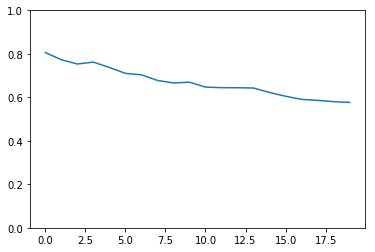

In [19]:
plt.plot(test_accuracies)
plt.ylim(ymin=0, ymax=1)
plt.show()

In [20]:
print(np.mean(test_accuracies))

0.6699402062598616


In [ ]:
%store -r DB1_test_accuracies
plt.plot(test_accuracies, color='g')
plt.plot(DB1_test_accuracies, color='b')
plt.ylim(ymin=0, ymax=1)
plt.show()

In [ ]:
plt.hist(tuner.appended_task_list[-1].train.weights[0 : tuner.appended_task_list[-2].train.weights.shape[0]], bins='auto')

In [ ]:
if use_tpu:
    sess.run(tpu.shutdown_system())

sess.close()

In [ ]:
import shelve
filename='code_state.bak'
my_shelf = shelve.open(filename,'n') # 'n' for new

for key in dir():
    try:
        my_shelf[key] = globals()[key]
    except TypeError:
        #
        # __builtins__, my_shelf, and imported modules can not be shelved.
        #
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()